#**1. Comprendiendo el problema a tratar**

Logramos obtener un conjunto de datos de un conjunto de pacientes diagnosticados con Parkinson y pacientes de control.

La **enfermedad de Parkinson (EP)** es una enfermedad neurodegenerativa crónica sin cura, caracterizada por una degeneración progresiva de las células nerviosas, disminuyendo la producción de dopamina, lo que resulta en graves alteraciones en el control del movimiento y la coordinación.

Las alteraciones motoras tempranas suelen manifestarse como **disartria** (afectación del habla asociada a rigidez de los músculos).

<center>
  <img src="https://i.ytimg.com/vi/gD80xdT_uLE/maxresdefault.jpg" width="600" height="400">
</center>

E **hipomimia** (afectación de la expresión facial asociada a lentitud de movimientos y rigidez).

<center>
  <img src="https://www.researchgate.net/publication/366948916/figure/fig1/AS:11431281160183154@1684634013197/Facial-expression-based-model-of-the-iPrognosis-app-for-detection-of-hypomimia-and.jpg" width="600" height="400">
</center>

Los pacientes con estos síntomas pueden experimentar dificultades para articular palabras o cambiar el tono de voz, lo que resulta en un habla difícil y monótona. Estos síntomas se manifiestan entre 7 y 11 años antes del diagnóstico de Parkinson. Hoy en día, estos patrones se caracterizan únicamente por pruebas observacionales, que dependen en gran medida de la experiencia del especialista.

La pregunta a responder es cómo podemos utilizar técnicas de análisis de video y audio para identificar patrones distintivos en los síntomas motores, como la rigidez facial y los trastornos del habla, y así desarrollar un enfoque multimodal que permita una detección precoz y precisa de la enfermedad, mejorando la calidad de vida de los pacientes y facilitando la planificación de tratamientos oportunos.

#**2. Acerca del set de datos**

La información recolectada por John se encuentra en [archiv CSV, carpetas, JSON, informacion]  con [n filas] y [n columnas]

Cada registro tiene [n caracteristicas] y una catergoría ("yes" o "no" depediendo de si la persona tiene Parkison o es paciente de control). Las columnas son:

1. "sex": genero (categórico: "masculino, "femenino")
2. "age": edad (numérica)
...

#3. **Lectura del dataset**

In [1]:
#@title Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Novedad - Para tratar con imágenes
import cv2 as cv
from PIL import Image

# Novedad - Para tratar con vídeos
from tqdm.notebook import tqdm # Nos permite iterar sobre imágenes
import subprocess

# Nos permite reproducir audios y vídeos en el Notebook
import IPython.display as ipd
from IPython.display import Video
from IPython.display import HTML

# Novedad - Para tratar con audios
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale # Para un proceso de normalización

# Para mejorar el diseño del Notebook
from itertools import cycle

sns.set_theme(style="white", palette = None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [3]:
#@title Lectura de los datos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Moverse a la carpeta donde están ubicados los datos del proyecto
%cd "drive/MyDrive/PROYECTO FINAL/Proyecto_Final_IA1_UIS"

/content/drive/.shortcut-targets-by-id/1iofm5cOxfKCz6ZivH_sK1yq51rsbAcUr/PROYECTO FINAL/Proyecto_Final_IA1_UIS


In [5]:
data_disartria = pd.read_csv("torgo_data/data.csv")
data_facial = pd.read_csv("facial_data/file_info.csv")

In [ ]:
print(data_disartria.shape, data_facial.shape)
data_disartria.head()
# data.describe()


(2000, 3) (7, 6)


,is_dysarthria,gender,filename
0,non_dysarthria,female,torgo_data/non_dysarthria_female/FC03_Session2...
1,non_dysarthria,female,torgo_data/non_dysarthria_female/FC02_Session3...
2,non_dysarthria,female,torgo_data/non_dysarthria_female/FC02_Session3...
3,non_dysarthria,female,torgo_data/non_dysarthria_female/FC03_Session2...
4,non_dysarthria,female,torgo_data/non_dysarthria_female/FC03_Session1...


In [ ]:
data_facial.head()

,assignment_id,worker_id,gender,age,country,resolution
0,0001d815c0--61dc3cd237bb0b17026609ea,e4dfe8860e51162b9887d1a14b2b5ba0,FEMALE,41,PL,240.0 x 320.0
1,0001d815c0--61e409908ccae11700e6a347,458fe395c77c079fba013b9b080bd054,FEMALE,45,RU,120.0 x 160.0
2,0001d815c0--61e561016090114967d86569,3fe8c977f4c80af79424c656f0175e37,MALE,45,RU,120.0 x 160.0
3,0001d815c0--61eeaf9928213259ef95a20a,e8ed3792b8a0c3193c165c3875bbfb65,FEMALE,20,RU,120.0 x 160.0
4,0001d815c0--61f3c3321e087a11af822fdc,1624db9d89e26abd544dd160ef7b2d87,MALE,28,RU,144.0 x 176.0


#**4. Análisis exploratorio**

Se llevaran a cabo las siguientes fases:
1. Análisis de cada variable de manera individual
2. Análisis univariado: relación de cada variable predictora con la variable a predecir
3. Análisis bivariado: relación de pares de pariables predictoras con la variable a predecir

##**4.1 Análisis de cada variable de manera individual**

In [ ]:
#@title Observar las caractreísticas de cada varibale
data_disartria.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   is_dysarthria  2000 non-null   object
 1   gender         2000 non-null   object
 2   filename       2000 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


In [ ]:
data_facial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   assignment_id  7 non-null      object
 1   worker_id      7 non-null      object
 2   gender         7 non-null      object
 3   age            7 non-null      int64 
 4   country        7 non-null      object
 5   resolution     7 non-null      object
dtypes: int64(1), object(5)
memory usage: 464.0+ bytes


Sinceramente, pienso que no podemos realizar un análisis exploratorio convencional, dado que posiblemente no podamos relacionar los datos de las personas con una imagen, entonces sería:

1. Mostrar los datos de las personas como lo hemos venido haciendo
2. Mostrar imágenes de paciente con Parkinson vs Control, asegurándonos de no revelar la identidad, y realizar un análisis subjetivo (o sea nosotros) de qué detalles podemos identificar entre los dos
3. Lo mismo para la parte del audio

Para hacer eso tendríamos que saber:

- Separar imágenes de audios (suponiendo que no esté separado)
- Mostrar imágenes y audios en Python

##**Análisis de vídeo para la hipomimia**

###**Obteniendo muestras de vídeo: género y caso disártrico**

In [6]:
data_facial.sample(frac=1).reset_index(drop=True,inplace=True)
sample_video = data_facial[(data_facial['gender']=='FEMALE')].sample(1)

In [35]:
ipd.Video(f'facial_data/live_videos/{sample_video.iloc[0].assignment_id}.mp4')

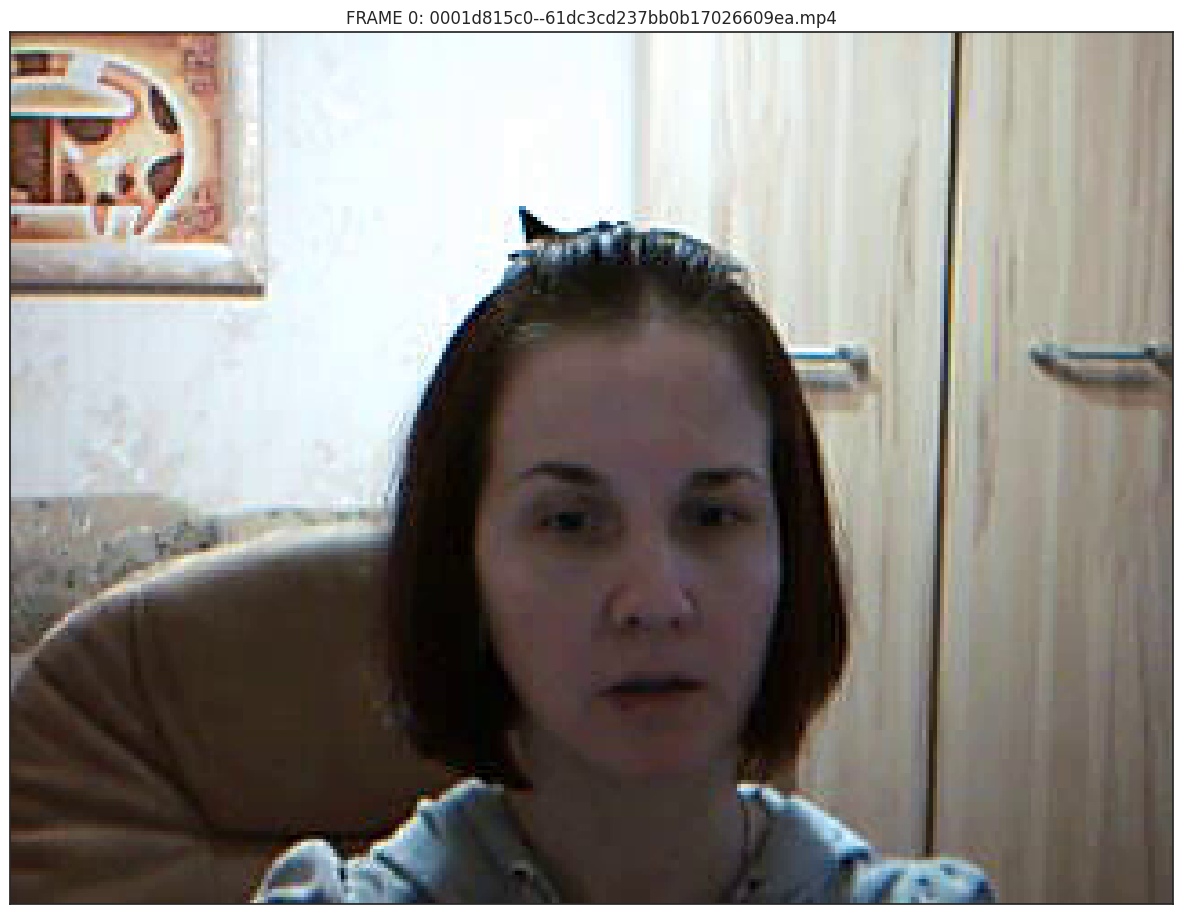

In [8]:
fig, ax = plt.subplots(1,1, figsize=(15, 15))
# train_video_files = [train_dir + x for x in os.listdir(train_dir)]
# video_file = train_video_files[30]
video_file = f'facial_data/live_videos/{sample_video.iloc[0].assignment_id}.mp4'
cap = cv.VideoCapture(video_file)
success, image = cap.read()
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
cap.release()
ax.imshow(image)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.title.set_text(f"FRAME 0: {video_file.split('/')[-1]}")
plt.grid(False)

Now lets use opencv to detect the faces using the face_recognition package! First we need to pip install it. Make sure you have internet turned on in your kernel.

Reference: https://github.com/ageitgey/face_recognition

In [9]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=f16c47bebceac85f71a6d734ad226d0d048a80f683edf1e4706abcf31aa75957
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


I found 1 face(s) in this photograph.
A face is located at pixel location Top: 106, Left: 126, Bottom: 196, Right: 215


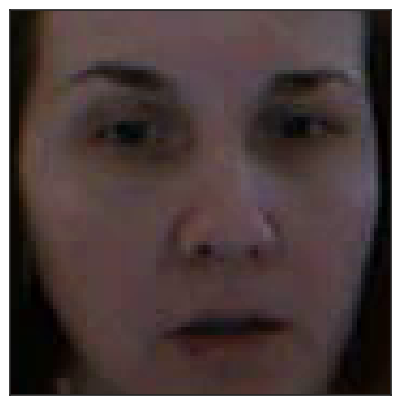

In [10]:
import face_recognition
face_locations = face_recognition.face_locations(image)

# https://github.com/ageitgey/face_recognition/blob/master/examples/find_faces_in_picture.py
from PIL import Image

print("I found {} face(s) in this photograph.".format(len(face_locations)))

for face_location in face_locations:

    # Print the location of each face in this image
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))

    # You can access the actual face itself like this:
    face_image = image[top:bottom, left:right]
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    plt.grid(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(face_image)

###**Locating a face landmarks within an image**

In [11]:
face_landmarks_list = face_recognition.face_landmarks(image)

The chin in this face has the following points: [(127, 134), (128, 147), (131, 160), (135, 172), (141, 183), (148, 193), (158, 200), (168, 206), (179, 207), (188, 204), (195, 197), (201, 188), (206, 178), (208, 167), (210, 156), (212, 144), (212, 133)]
The left_eyebrow in this face has the following points: [(137, 125), (143, 120), (150, 118), (158, 120), (165, 124)]
The right_eyebrow in this face has the following points: [(184, 124), (190, 120), (197, 119), (203, 120), (207, 124)]
The nose_bridge in this face has the following points: [(176, 134), (177, 142), (178, 150), (179, 158)]
The nose_tip in this face has the following points: [(168, 164), (173, 165), (178, 166), (182, 165), (185, 163)]
The left_eye in this face has the following points: [(146, 135), (151, 132), (157, 132), (162, 136), (157, 137), (151, 138)]
The right_eye in this face has the following points: [(185, 136), (190, 132), (196, 131), (200, 134), (196, 136), (191, 137)]
The top_lip in this face has the following p

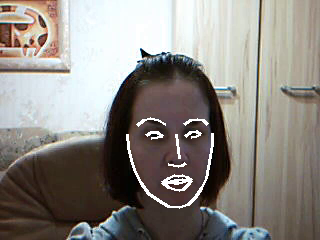

In [12]:
# https://github.com/ageitgey/face_recognition/blob/master/examples/find_facial_features_in_picture.py
# face_landmarks_list
from PIL import Image, ImageDraw
pil_image = Image.fromarray(image)
d = ImageDraw.Draw(pil_image)

for face_landmarks in face_landmarks_list:

    # Print the location of each facial feature in this image
    for facial_feature in face_landmarks.keys():
        print("The {} in this face has the following points: {}".format(facial_feature, face_landmarks[facial_feature]))

    # Let's trace out each facial feature in the image with a line!
    for facial_feature in face_landmarks.keys():
        d.line(face_landmarks[facial_feature], width=3)

# Show the picture
display(pil_image)

###**Displaying many test examples and labels**

In [27]:
print(f'facial_data/live_videos/{sample_video.iloc[0].assignment_id}.mp4')

facial_data/live_videos/0001d815c0--61dc3cd237bb0b17026609ea.mp4


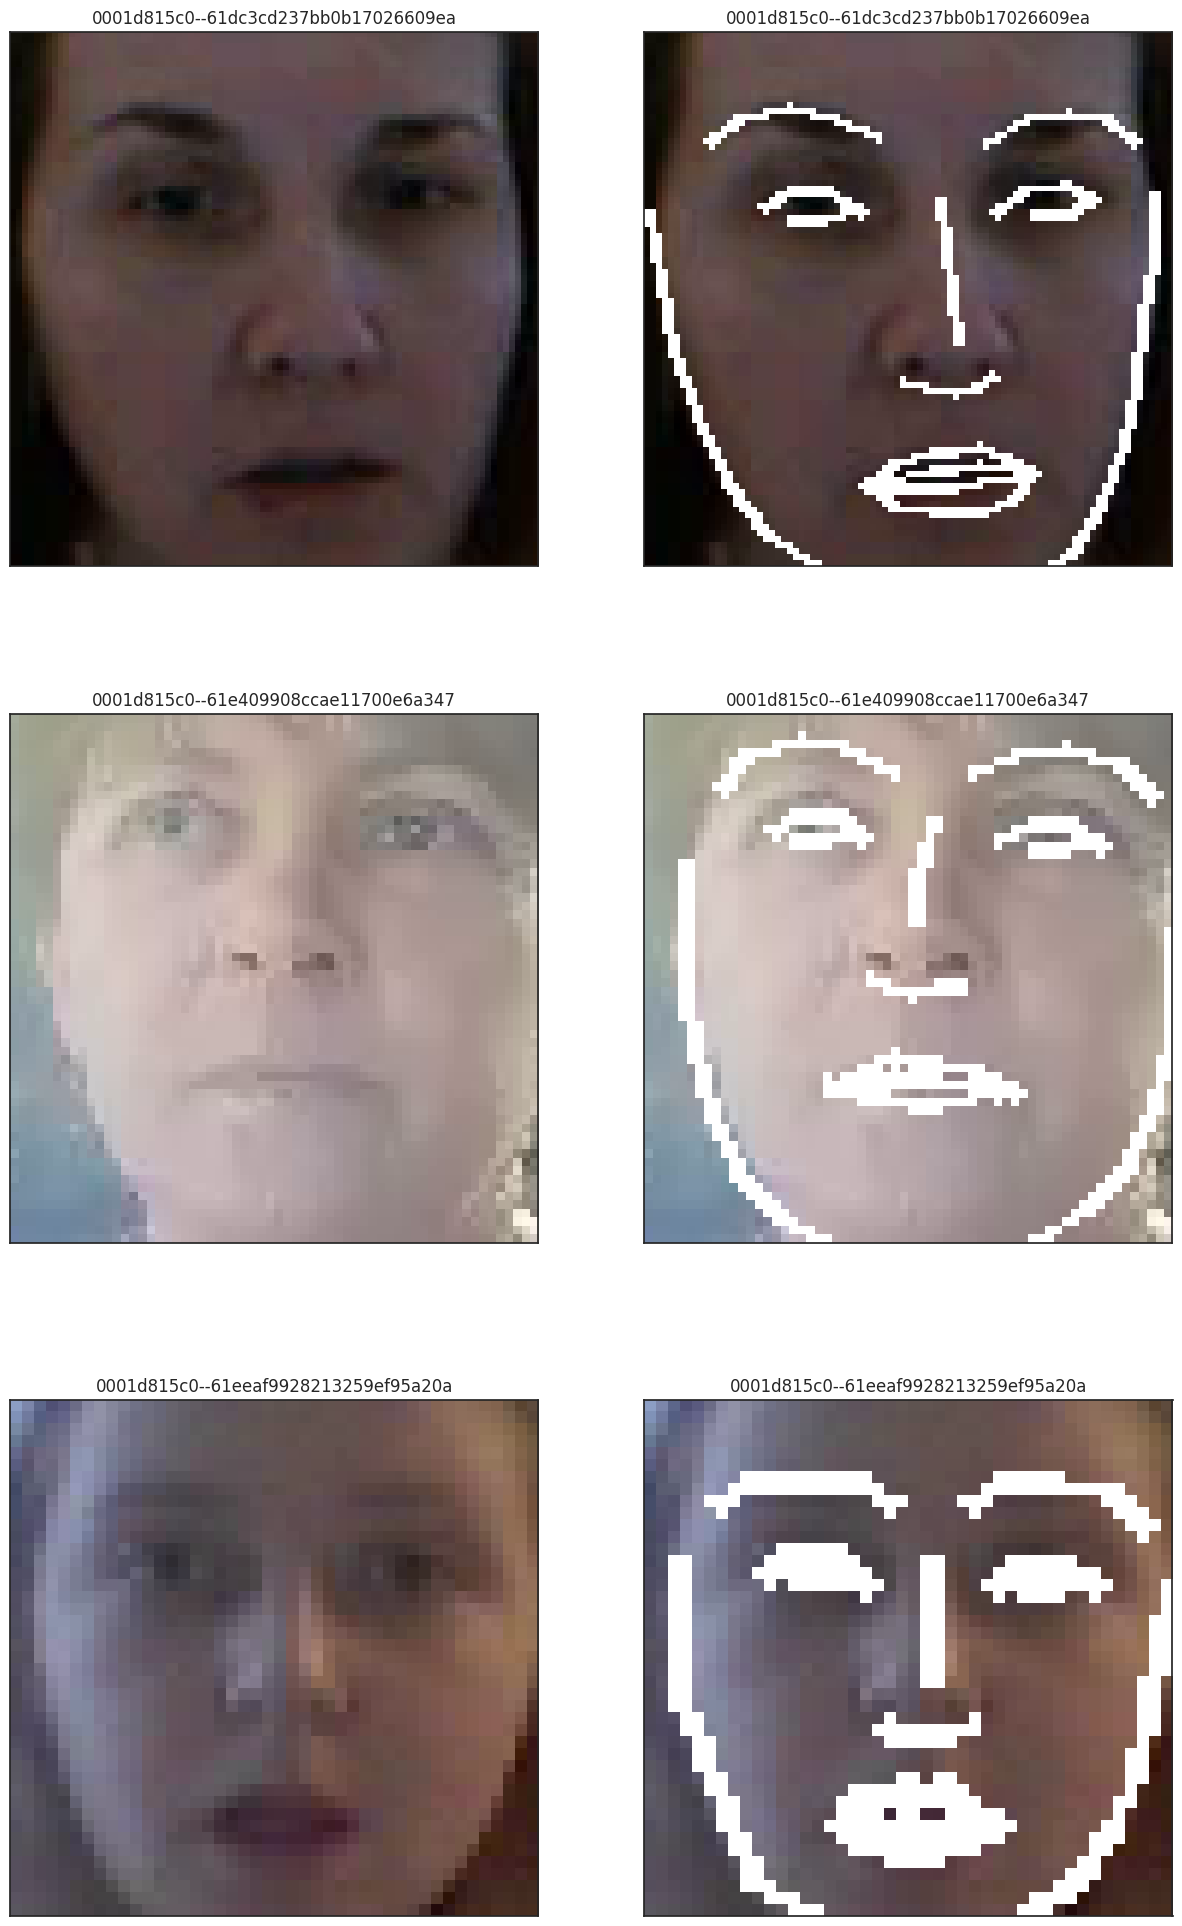

In [36]:
fig, axs = plt.subplots(3, 2, figsize=(15, 25))
axs = np.array(axs)
axs = axs.reshape(-1)
i = 0
for fn in data_facial.assignment_id[:4]:
    # label = data_facial.iloc[fn]['worker_id']
    # orig = data_facial.loc[fn]['label']
    video_file = f'facial_data/live_videos/{fn}.mp4'
    ax = axs[i]
    cap = cv.VideoCapture(video_file)
    success, image = cap.read()
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(image)
    if len(face_locations) > 0:
        # Print first face
        face_location = face_locations[0]
        top, right, bottom, left = face_location
        face_image = image[top:bottom, left:right]
        ax.imshow(face_image)
        ax.grid(False)
        # ax.title.set_text(f'{fn} - {label}')
        ax.title.set_text(f'{fn}')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        # Find landmarks
        face_landmarks_list = face_recognition.face_landmarks(face_image)
        face_landmarks = face_landmarks_list[0]
        pil_image = Image.fromarray(face_image)
        d = ImageDraw.Draw(pil_image)
        for facial_feature in face_landmarks.keys():
            d.line(face_landmarks[facial_feature], width=2)
        landmark_face_array = np.array(pil_image)
        ax2 = axs[i+1]
        ax2.imshow(landmark_face_array)
        ax2.grid(False)
        # ax2.title.set_text(f'{fn} - {label}')
        ax2.title.set_text(f'{fn}')
        ax2.xaxis.set_visible(False)
        ax2.yaxis.set_visible(False)
        i += 2
plt.grid(False)
plt.show()

##**Análisis del audio para la disartria**

Primero hay que definir algunas caracterísitcas descriptivas de las señales de sonido.

1. **Forma de onda (Waveform)**: Es una representación gráfica de una onda de sonido a medida que se mueve a través de un medio a lo largo del tiempo.

2. **Espectograma (Spectogram)**: Es una figura que
representa el espectro de frecuencias de un audio grabado a lo largo del tiempo. Esto significa que a medida que el color de la figura se vuelve más brillante, el sonido se concentra en gran medida alrededor de esas frecuencias específicas, y a medida que el color se vuelve más oscuro, el sonido se acerca al sonido vacío/muerto.

3. **Tasa de cruce por cero (Zero crossing rate)**: La calificación de cruce por cero es no. de veces la señal cambia su valor de positivo a negativo o viceversa dividido por la longitud del cuadro.

4. **Centroide espectral (Spectral Centroid)**: Representa el centro de masa del espectro. Nos da la banda de frecuencia donde se concentra la mayor parte de la energía. Los centroides suelen estar altos cuando no hay voz y se vuelven bajos en aquellos casos en los que la voz está presente en el audio.

5. **Caída espectral (Spectral Roll-off)**: La caída espectral representa la frecuencia por debajo de la cual un cierto porcentaje (normalmente entre el 80 % y el 90 %, librosa: 85%) de la distribución de magnitud del espectro se concentra en el espectro.

6. **MFCC (Mel-frequency cepsral coefficients)**: Es una representación compacta del espectro de frecuencias de un audio. Se calcula en seis pasos y proporciona una representación de baja dimensión que captura las características más importantes del espectro de frecuencias.
<center>
  <img src="https://www.researchgate.net/publication/331275489/figure/fig2/AS:729006496292864@1550820101122/Steps-involved-in-MFCC-feature-extraction.png" width="600" height="400">
</center>

7. **Espectrograma Mel (Mel Spectrogram)**: Es un espectrograma donde las frecuencias se convierten a la escala Mel. La escala Mel muestra las magnitudes que son más perceptibles para el oído humano en general.

In [ ]:
#@title Definiendo las funciones de visualización

def show_waveplot(audio_path,label,gender):
    x , sr = librosa.load(audio_path)
    plt.figure(figsize=(20, 6))
    librosa.display.waveshow(x, sr=sr)
    plt.title(f"Waveplot: of Class: {label}, Gender: {gender}")

def show_spectrogram(audio_path,label,gender):
    x , sr = librosa.load(audio_path)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(20,6))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',cmap='plasma')
    plt.colorbar()
    plt.title(f"Spectrogram of Class: {label}, Gender: {gender}")

def show_zcr(audio_path,label,gender):
    x , sr = librosa.load(audio_path)
    zero_crossings = librosa.zero_crossings(x)
    print("Sum of zero crossing ", zero_crossings.sum())
    plt.figure(figsize=(20, 5))
    plt.title(f'Zero Crossing Rate of Class: {label}, Gender: {gender}')
    zcrs = librosa.feature.zero_crossing_rate(x)
    plt.plot(zcrs[0])
    plt.show()

def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

def show_spectral_centroids(audio_path,label,gender):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Centroids of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    plt.show()

def show_spectral_rolloff(audio_path,label,gender):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Rolloff of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr, roll_percent=0.01)[0]
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_rolloff), color='r')
    plt.show()

def show_mfccs(audio_path,label,gender):
    plt.figure(figsize=(20, 6))
    plt.title(f'MFCC of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time',cmap='plasma')
    plt.show()

def show_melspectro(audio_path,label,gender):
    plt.figure(figsize=(20, 6))
    plt.title(f'Mel Spectro of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    melspectro = librosa.feature.melspectrogram(y=x, sr=sr)
    librosa.display.specshow(melspectro, sr=sr, x_axis='time',cmap='plasma')
    plt.show()

###**Obteniendo muestras de audio: género y caso disártrico**

In [ ]:
data_disartria.sample(frac=1).reset_index(drop=True,inplace=True)
male_dysarthric = data_disartria[(data_disartria['gender']=='male') & (data_disartria['is_dysarthria']=='dysarthria')].sample(1)
male_ndysarthric = data_disartria[(data_disartria['gender']=='male') & (data_disartria['is_dysarthria']=='non_dysarthria')].sample(1)

In [ ]:
#@title Hombre con disartria
ipd.Audio(male_dysarthric.iloc[0].filename)

In [ ]:
#@title Hombre sin disartria
ipd.Audio(male_ndysarthric.iloc[0].filename)

#### **Waveplots**


*   Para las muestra disártrica se puede observar que la muestra masculina tiene un habla arrastrada como es evidente en el diagrama de ondas.
*   Las muestras no disártricas tienen una gráfica de onda regular que indica un habla a un ritmo regular.



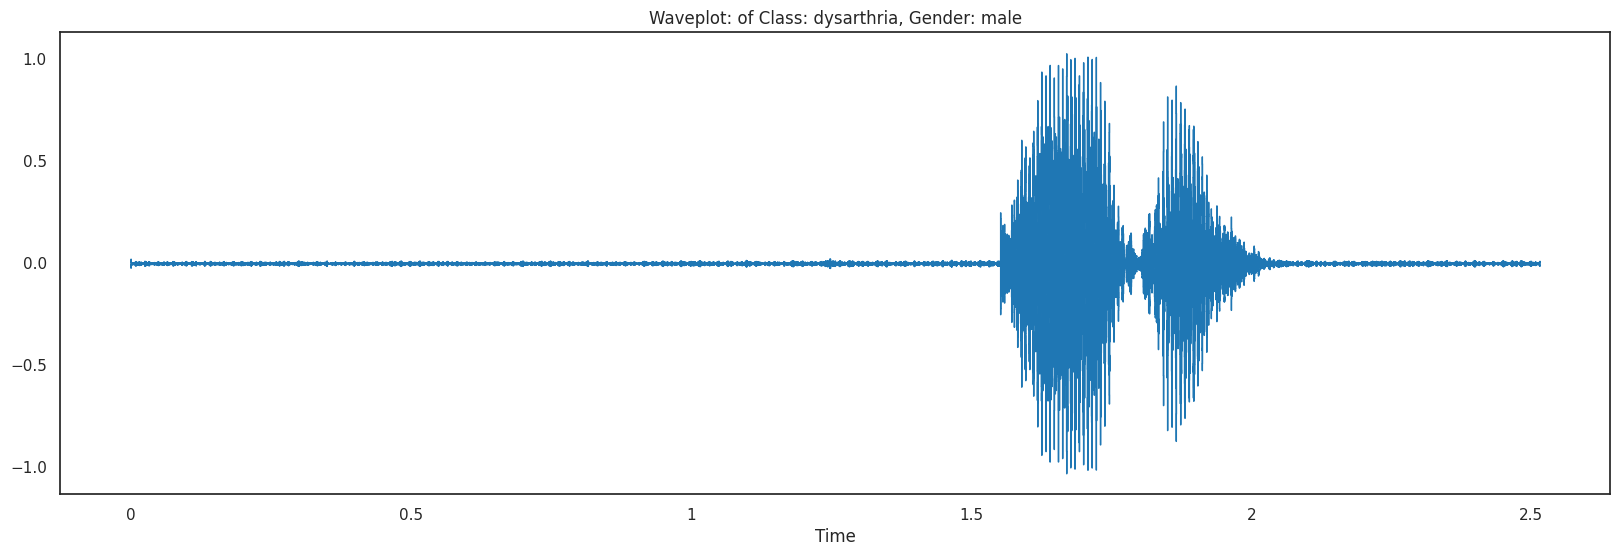

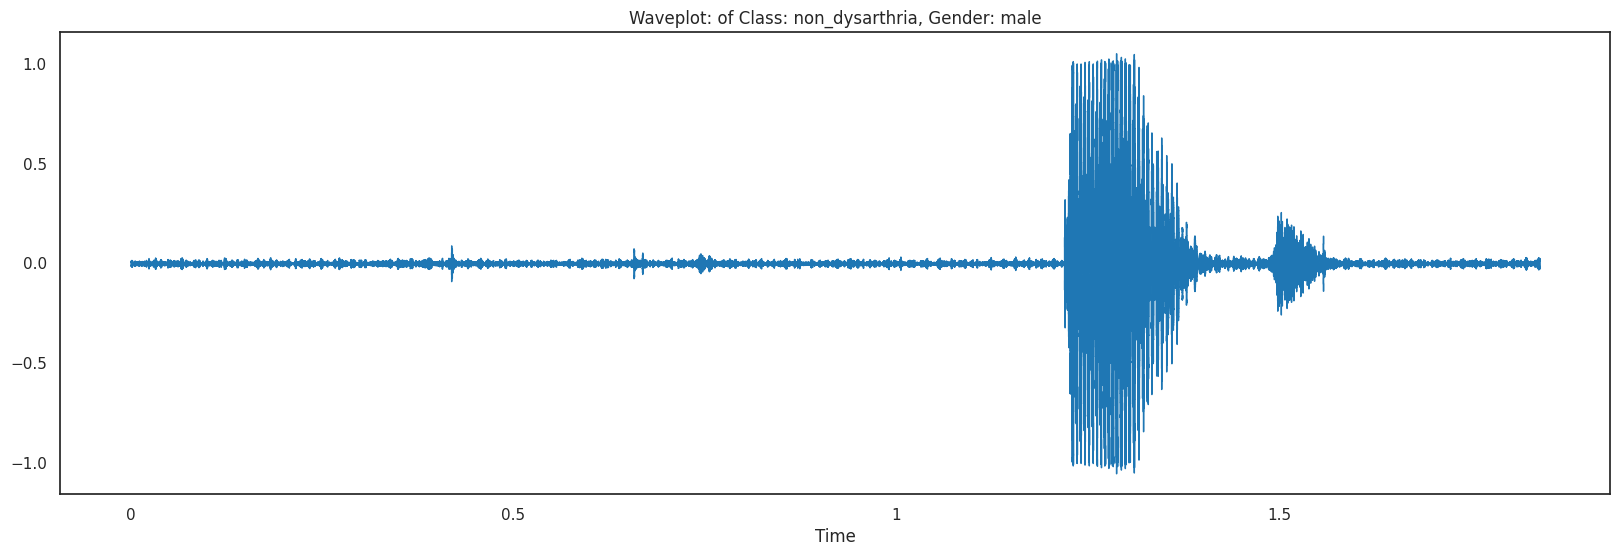

In [ ]:
show_waveplot(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_waveplot(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)

#### **Spectrograms**


*   Para las muestras disártricas se puede ver que las magnitudes de energía de las frecuencias están más dispersas a lo largo del tiempo, lo que indica un habla lenta y confusa o debido al hecho de que las palabras salen más rápidamente y se superponen entre sí. También podrían ser posibles patrones similares para una persona disártrica y que habla de forma monótona.
*   Para las muestras no disártricas se puede ver que las magnitudes de energía están más reducidas a solo las partes donde han hablado algo, que es a un ritmo regular.



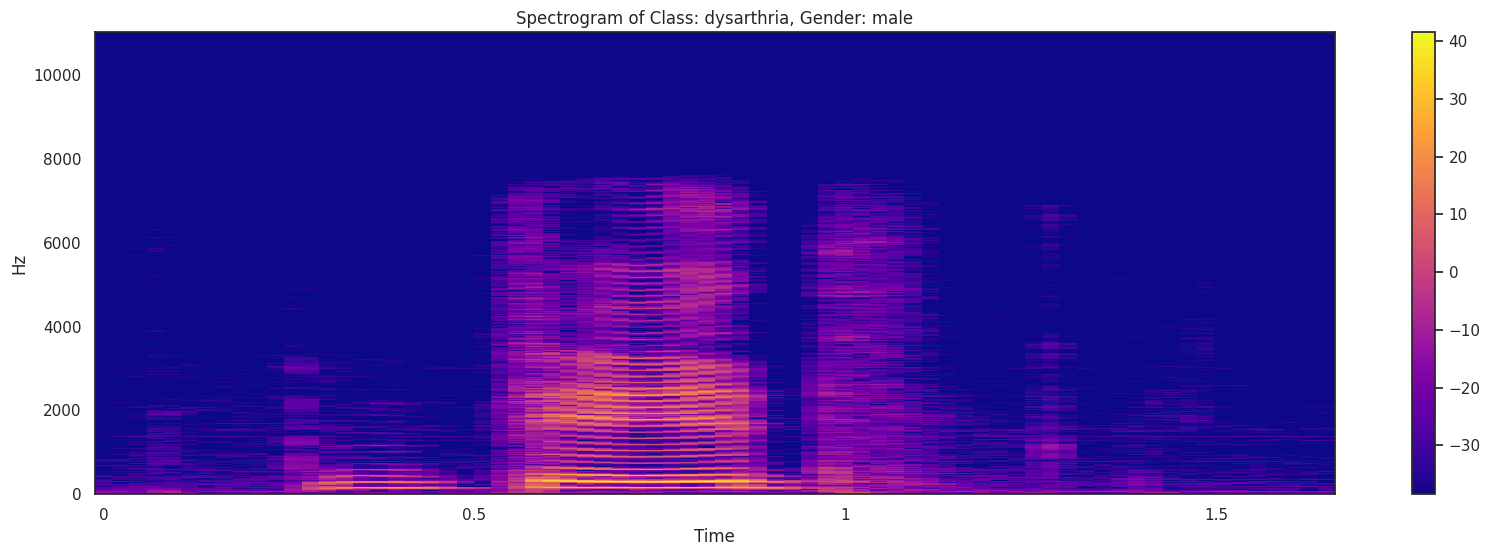

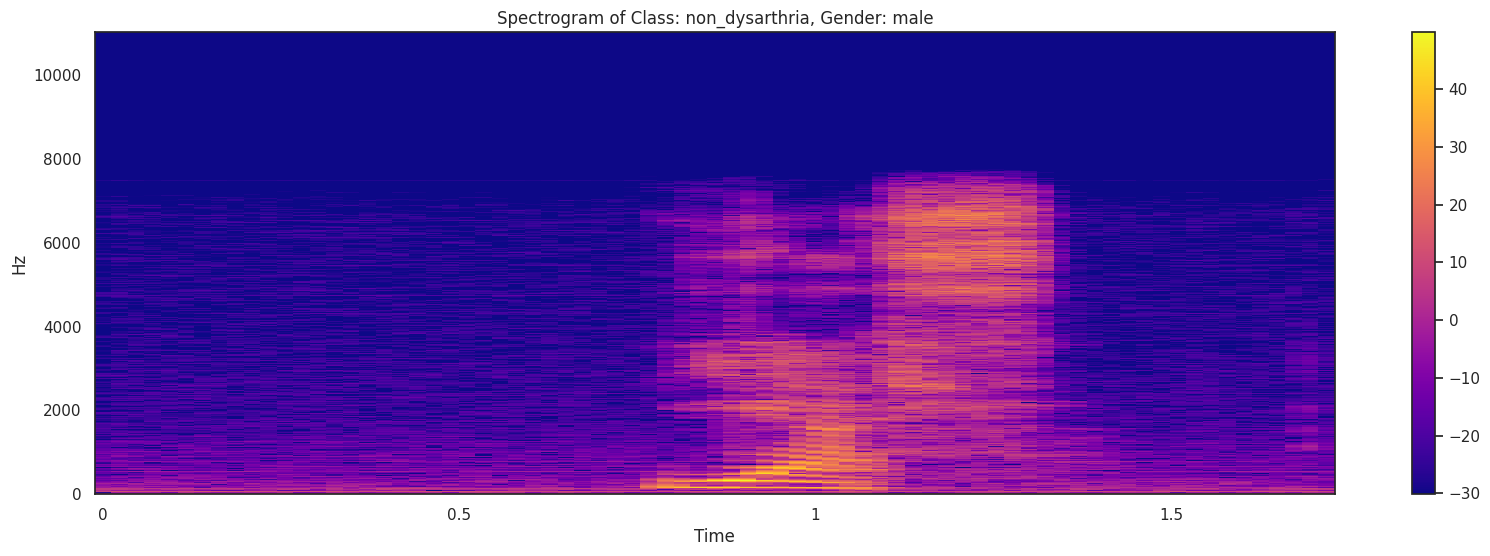

In [ ]:
show_spectrogram(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_spectrogram(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)

#### **Zero Crossing Rate**


*   Para las muestras disártricas, se puede observar que en el audio mismo hubo casos en los que algunas de las frases de las palabras eran relativamente más fuertes y, por lo tanto, hay múltiples picos de tasa de cruce por cero en esos casos. Este volumen repentino de ciertas palabras podría deberse a su falta de control sobre la lengua y otros músculos relacionados con la boca mientras hablan y a no poder enfatizar las palabras intencionalmente.
*   Para los casos no disártricos, la tasa de cruce por cero es alta en aquellos casos en los que la voz del hablante es audible.



Sum of zero crossing  2918


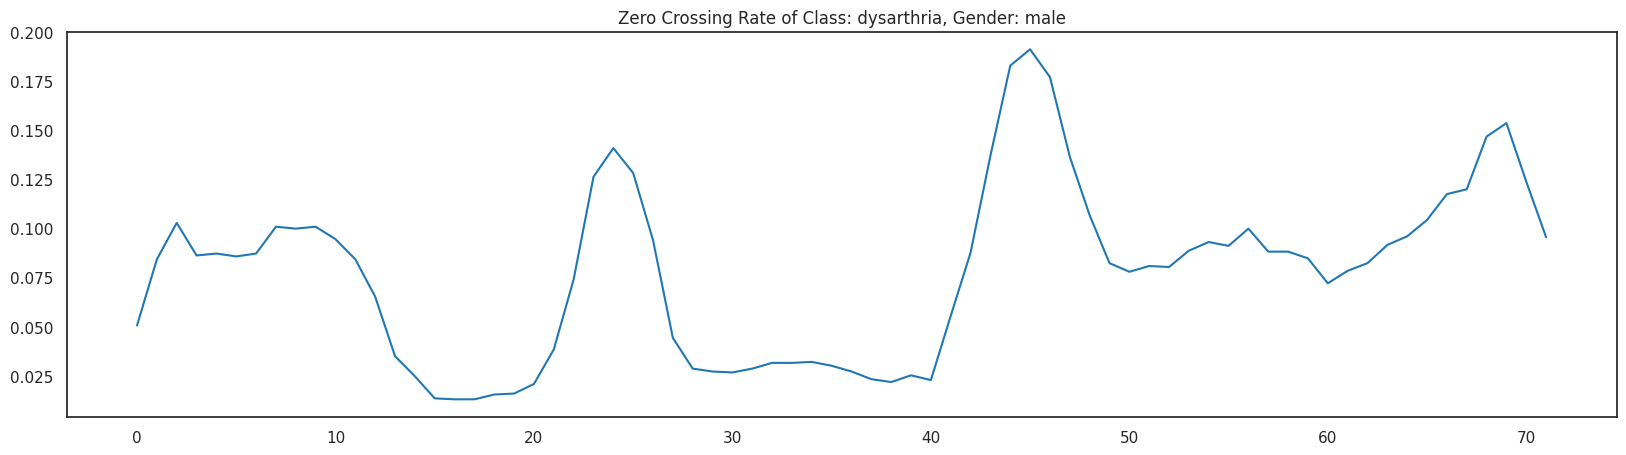

Sum of zero crossing  4292


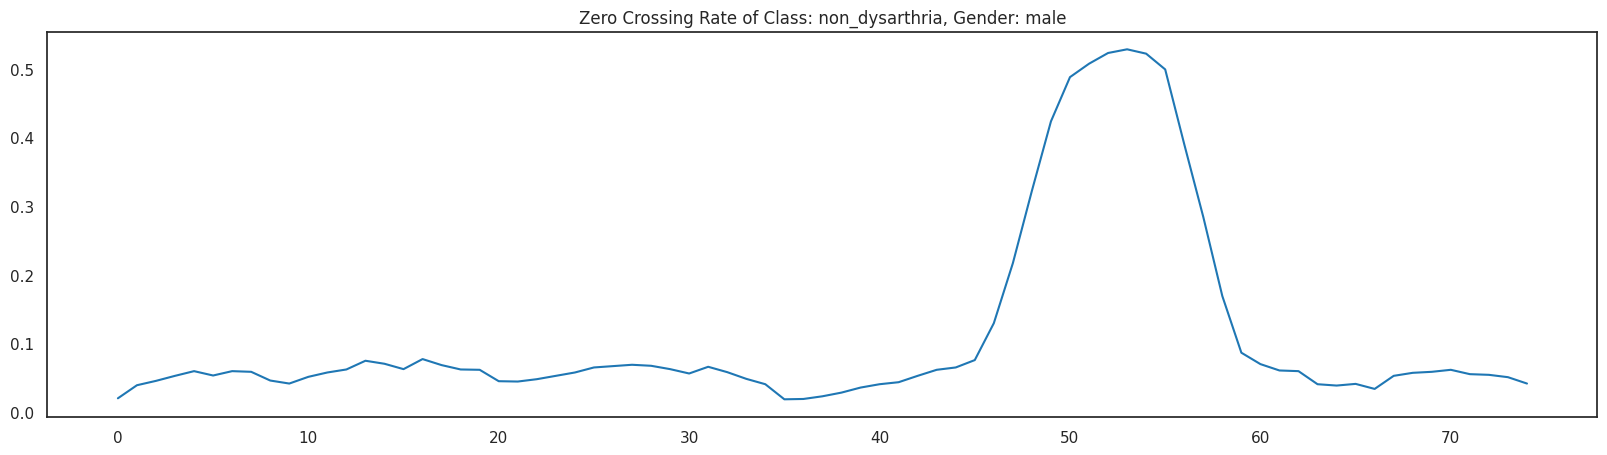

In [ ]:
show_zcr(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_zcr(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)

#### **Spectral Centroid**


*   Para muestras disártricas se puede ver que debido a que el habla es confusa, los valores del centroide bajan por un tiempo y vuelven a subir tan pronto como hay algunas pequeñas pausas.
*   Para muestras no disártricas, los centroides están abajo por un momento cuando el habla está presente en el audio y vuelven a subir tan pronto como no hay voz en el audio.



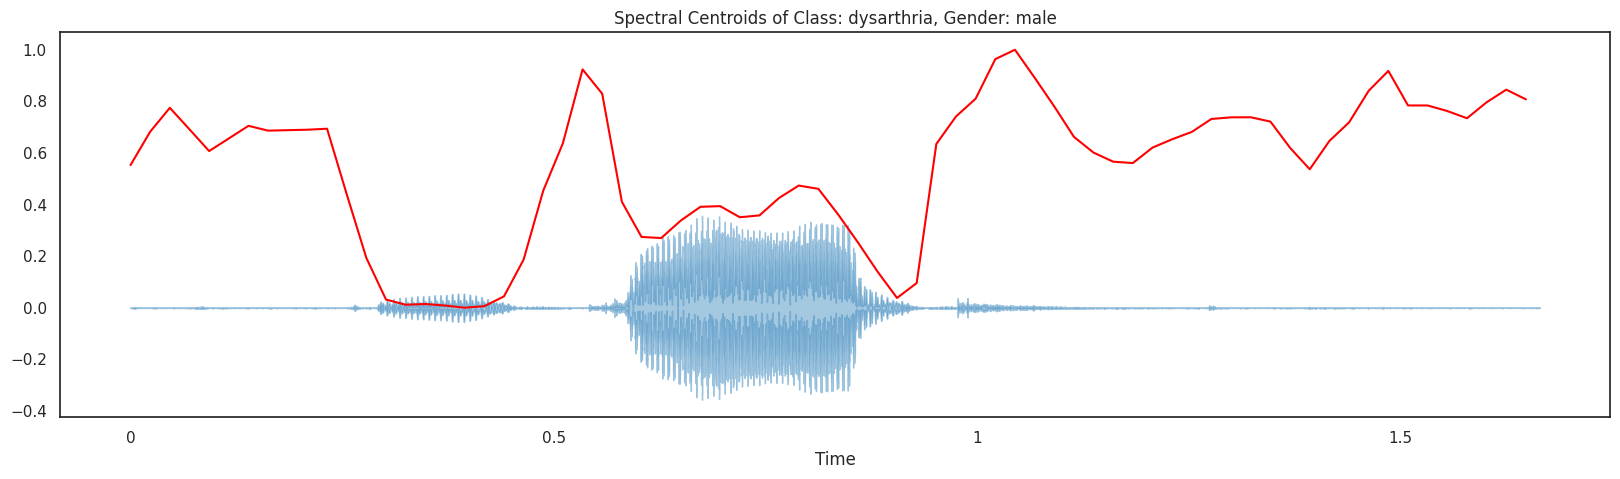

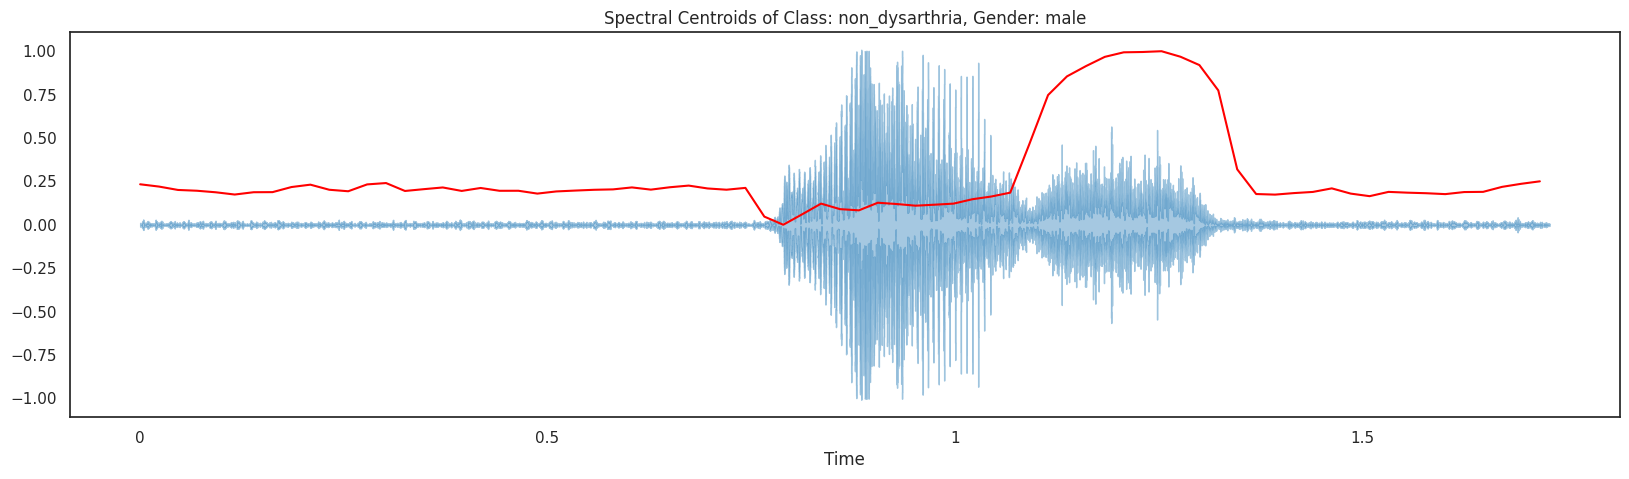

In [ ]:
show_spectral_centroids(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_spectral_centroids(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)

#### **Spectral Rolloff**


*   Como habíamos observado anteriormente en los espectrogramas las magnitudes de energía de las frecuencias están más dispersas en el caso de muestras disártricas, se puede ver la cobertura del 85% por debajo de la frecuencia de caída envolviendo el habla presente en la señal de audio.
*   Para muestras no disártricas podemos ver que la cobertura del 85% incluye el habla así como algunas otras perturbaciones/ruido en el audio.



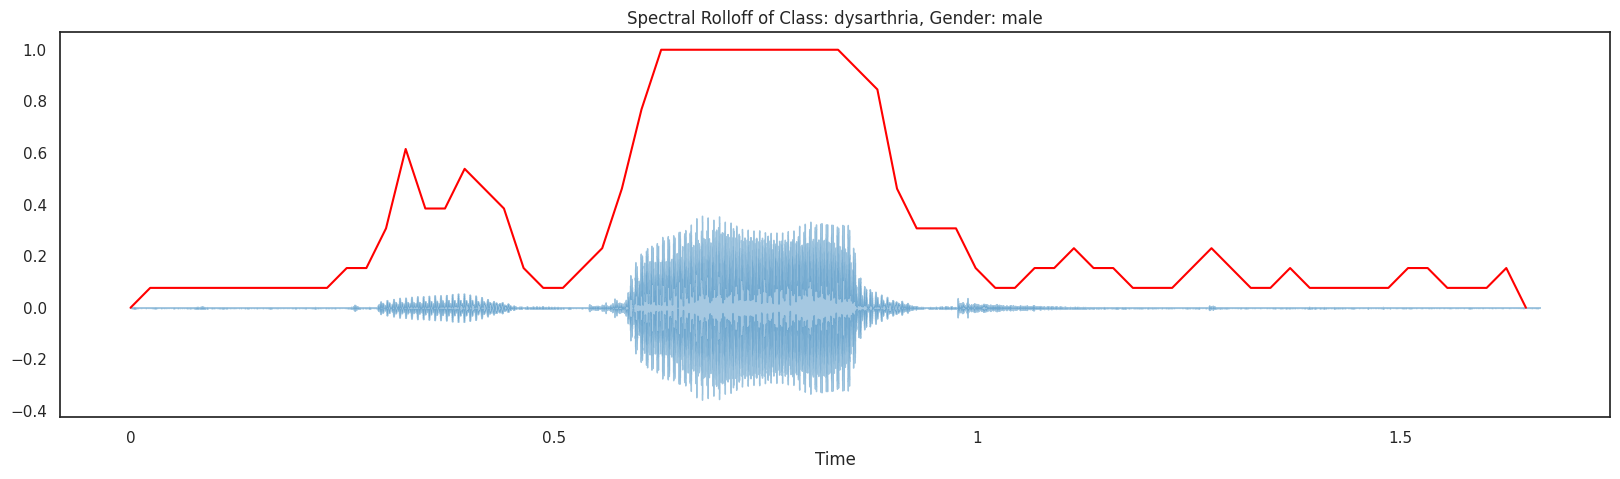

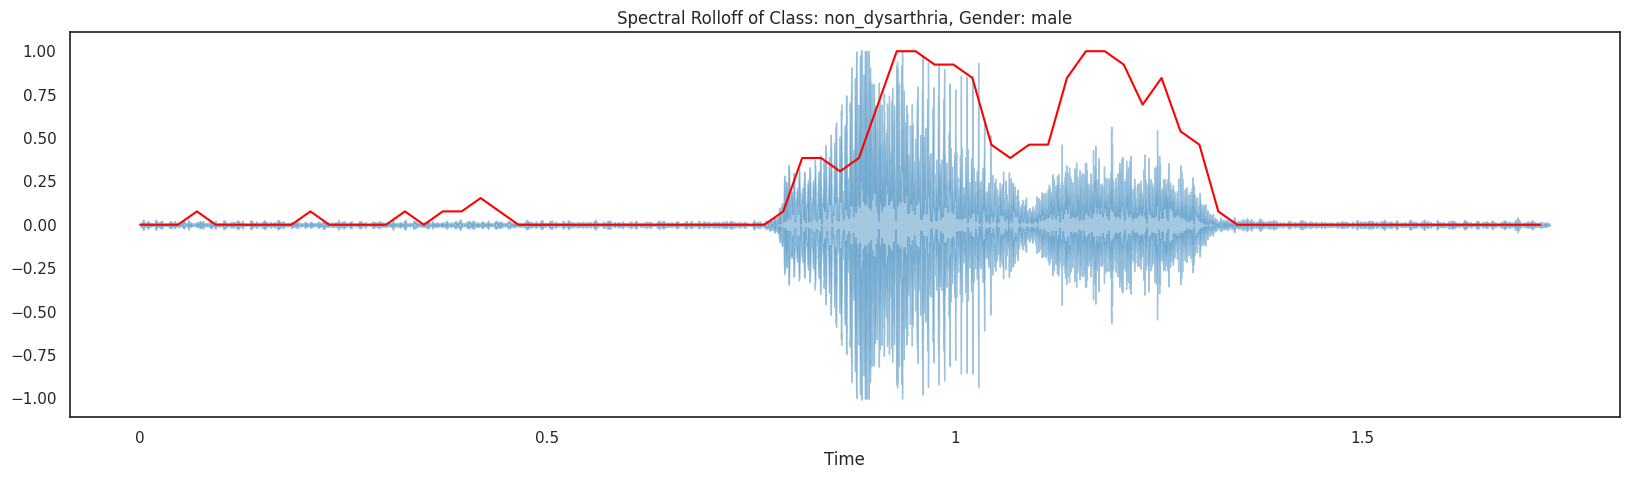

In [ ]:
show_spectral_rolloff(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_spectral_rolloff(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)

#### **MFCCs**


*   Para muestras disártricas, la visualización de MFCC tiene píxeles mucho más oscuros y concentrados que indican los arrastres presentes en su habla.
*   Para los no disártricos no está tan concentrado y está más extendido.



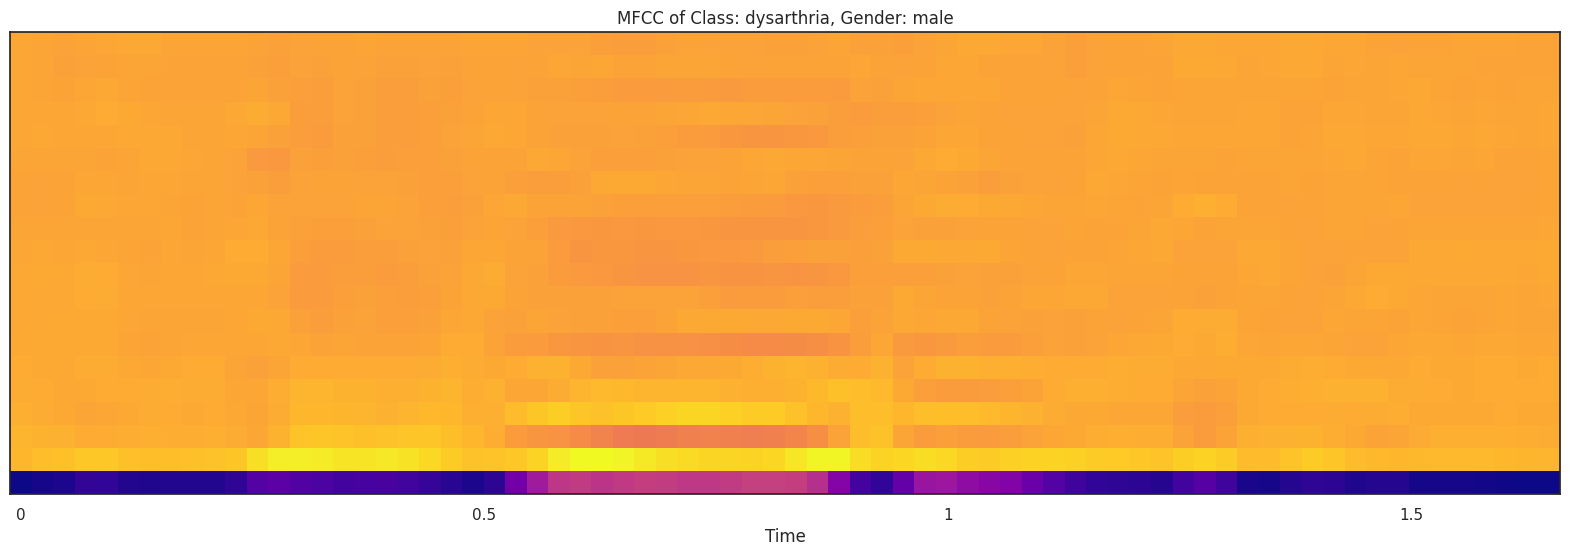

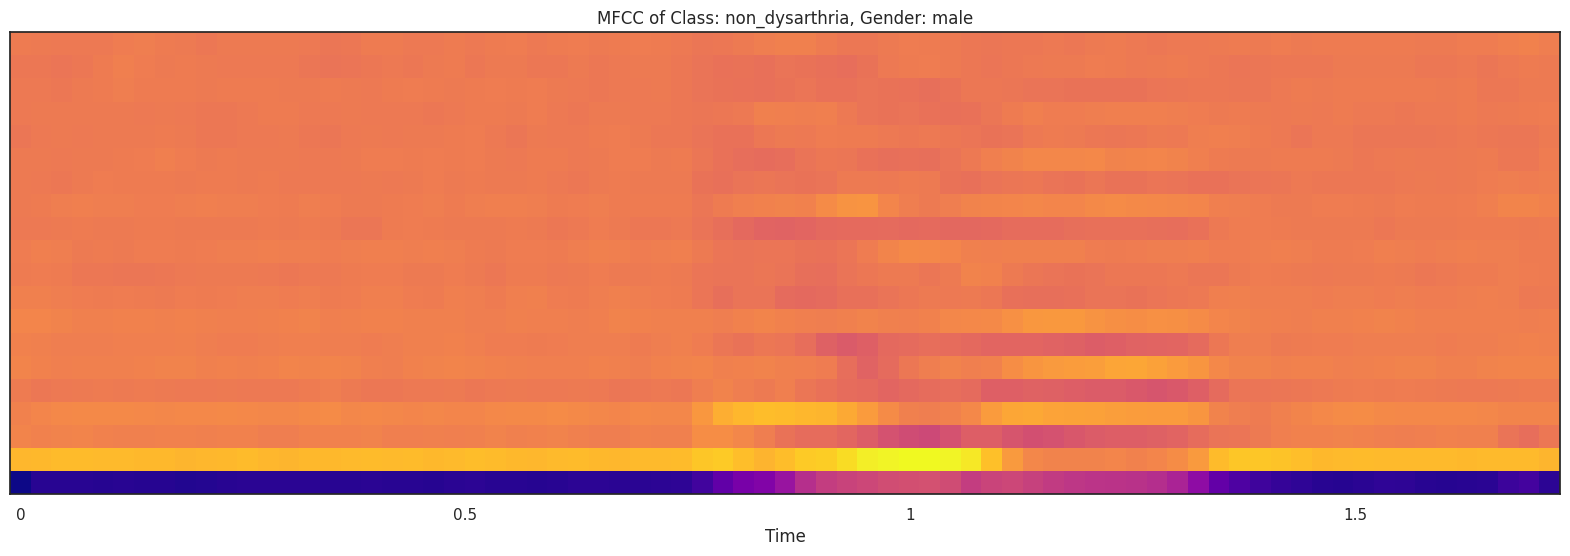

In [ ]:
show_mfccs(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_mfccs(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)

#### **Mel Spectrogram**


*   Los patrones en los espectrogramas Mel de las muestras disártricas son algo indicativos de los arrastres en el habla.



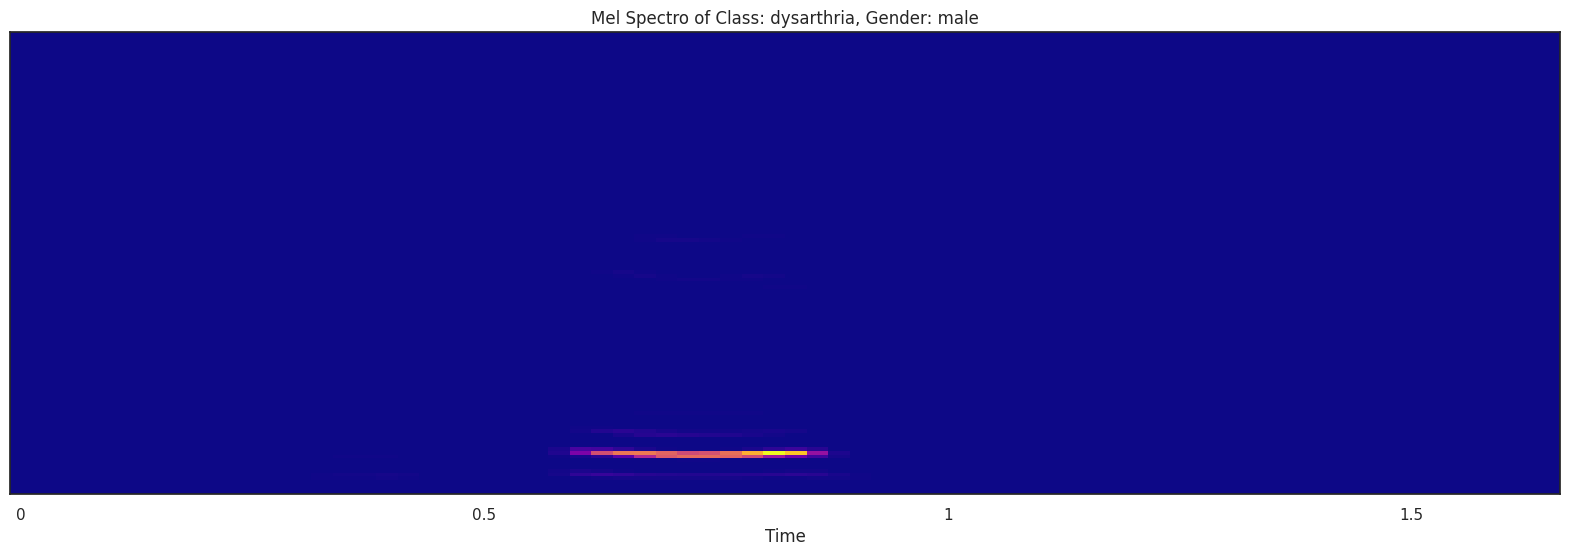

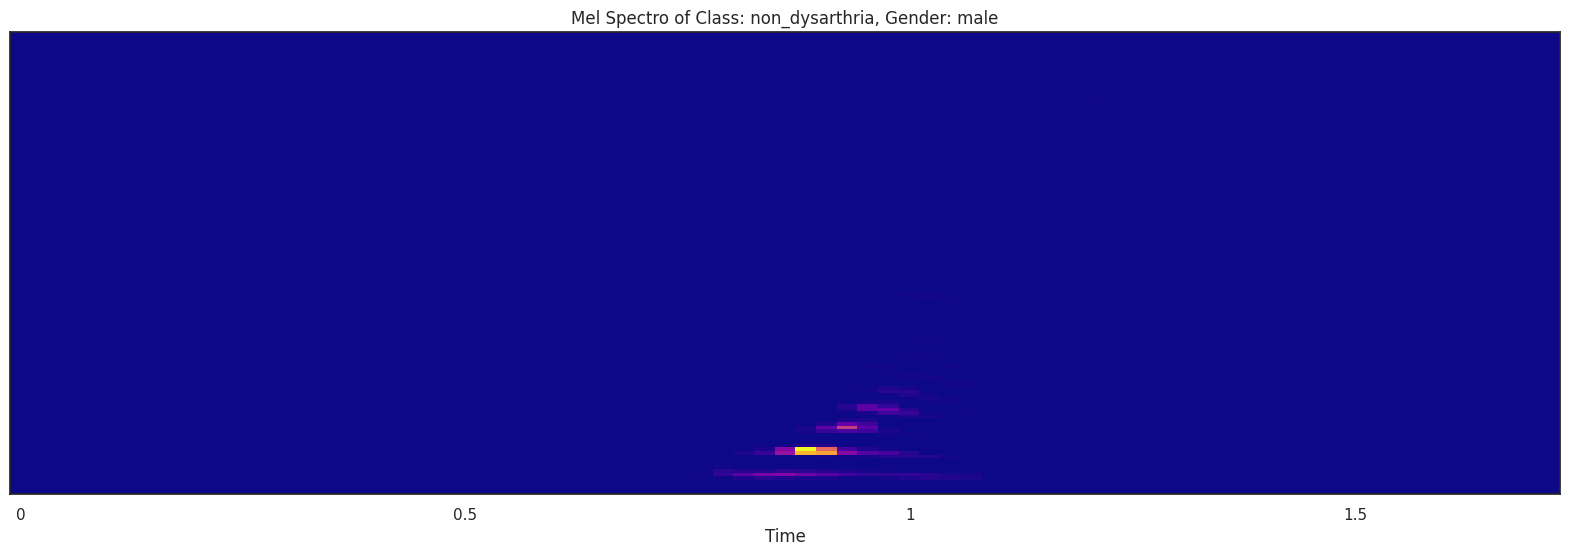

In [ ]:
show_melspectro(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_melspectro(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)

#**Extra (se tiene que quitar): Manejo de archivos (imágenes y audio)**

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')
# Esta es una carpeta en mi drive
%cd /content/gdrive/MyDrive/semilleroEstudiantes/introducción a python

Mounted at /content/gdrive/
/content/gdrive/MyDrive/semilleroEstudiantes/introducción a python


## Imágenes

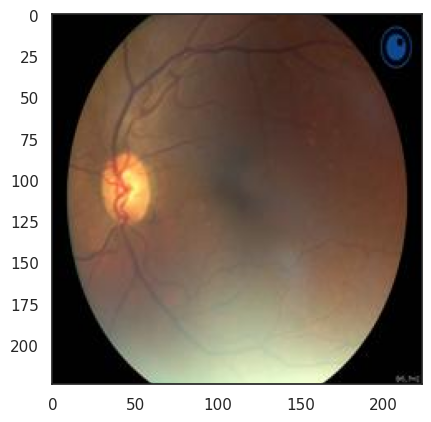

In [ ]:
#@title Mostrando imágenes con PIL y Matplotlib


# import matplotlib.pyplot as plt
# import numpy as np
# from PIL import Image

img = np.asarray(Image.open('imagenes/IM0535EY.JPG'))
imgplot = plt.imshow(img)

Altura: 224, Ancho: 224, Canales (RGB):3


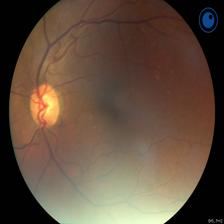

In [ ]:
#@title Mostrando imágenes con Open CV
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread('imagenes/IM0535EY.JPG')
(h, w, c) = image.shape[:3]
print(f"Altura: {h}, Ancho: {w}, Canales (RGB):{c}")
cv2_imshow(image)

#**N. Bibliografía**


*   Reichmann, H., Klingelhoefer, L., Bendig, J. (2023). "The use of wearables for the diagnosis and treatment of Parkinson’s disease." Journal of Neural Transmission, 130(2023), 783–791. Publicado en línea el 7 de enero de 2023. Figura 1: Facial expression-based model of the iPrognosis app for detection of hypomimia and depression.
*   V. L. Feigin et al., “Global, regional, and national burden of neurological disorders, 1990–2016: a systematic analysis for the global burden of disease study 2016,” The Lancet Neurology, vol. 18, no. 5, pp. 459–480, 2019
*   J. Rusz et al., “Distinct patterns of speech disorder in early-onset and late-onset de-novo parkinson’s disease,” npj Parkinson’s Disease, vol. 7, no. 1, p. 98, 2021
*   L. Ricciardi, A. De Angelis, et al., “Hypomimia in parkinson’s disease: an axial sign responsive to levodopa,” European Journal of Neurology, vol. 27, no. 12, pp. 2422–2429, 2020.
*   R. B. Postuma et al., “How does parkinsonism start? prodromal parkinsonism motor changes in idiopathic rem sleep behaviour disorder,” Brain, vol. 135, no. 6, pp. 1860–1870, 2012
*   S.-M. Fereshtehnejad et al., “Evolution of prodromal parkinson’s disease and dementia with lewy bodies: a prospective study,” Brain, vol. 142, no. 7, pp. 2051–2067, 2019.
*   J. Alegre-Ayala et al., “The impact of parkinson’s disease severity on performance of activities of daily living: an observational study,” Revista de Neurolog´ıa, vol. 76, no. 8, p. 249, 2023.
*   J. H. Friedman, “Misperceptions and parkinson’s disease,” Journal of the Neurological Sciences, vol. 374, pp. 42–46, 2017.







